In [263]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter
from ray.air import session 


In [264]:
def get_datas(csv_path):
    data = pd.read_csv(csv_path,index_col=None)
    
    # 特徴量とターゲット変数の分割,DFのvalueのみ抽出
    X = data.drop('dengue', axis=1).values  
    y = data['dengue'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    #numpy配列をtensolに変換
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    #TensorDatasetの作成
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    return train_dataset,train_loader,X_test_tensor,y_test_tensor
    

In [265]:
class BinaryClassificationNN(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 16)
        self.fc5=nn.Linear(16,1)
        self.dropout_1 = nn.Dropout(p=0.25)
        self.dropout_2 = nn.Dropout(p=0.1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout_2(x) 
        
        x = torch.relu(self.fc2(x))
        x = self.dropout_2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.dropout_1(x)
        
        x = torch.relu(self.fc4(x))
        x = self.dropout_1(x)
        
        x = torch.sigmoid(self.fc5(x))
        
        return x


In [266]:
def train_classification_nn(config, train_loader, input_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = BinaryClassificationNN(input_size).to(device)
    
    # 複数GPUの場合はDataParallelを使用
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    criterion = nn.BCELoss() 
    optimizer = optim.Adam(model.parameters(), lr=config["lr"],weight_decay=0.0001)

    for epoch in range(config["epochs"]):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            # デバイスにテンソルを移動
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Ray TuneのセッションAPIを使用して損失を報告
        session.report({"loss": running_loss / len(train_loader)})

In [267]:
def tune_nn(input_size, train_loader):
    train_loader = train_loader

    # 設定の修正: weight_decayの範囲を修正し、名前を修正
    config = {
        "lr": tune.loguniform(1e-7, 1e-1),  
        "epochs": tune.choice([100, 200, 300, 400, 500])
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=30,
        grace_period=1,
        reduction_factor=2
    )

    reporter = CLIReporter(metric_columns=["loss", "training_iteration"])

    result = tune.run(
        tune.with_parameters(train_classification_nn, train_loader=train_loader, input_size=input_size),
        resources_per_trial={"cpu": 1, "gpu": 0.5},
        config=config,
        num_samples=10,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final loss: {}".format(best_trial.last_result["loss"]))

    return best_trial.config


In [268]:
def optimized_nn(input_size, train_loader, best_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = BinaryClassificationNN(input_size).to(device)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)

    epochs = best_config['epochs']
    lr = best_config['lr']
    
    criterion = nn.BCELoss()  # バイナリクロスエントロピー
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=0.0001)

    losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            
            # デバイスにテンソルを移動
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.float())
            loss.backward()
            optimizer.step()

            # バッチごとの損失を累計
            running_loss += loss.item() * X_batch.size(0)

            # バッチごとの損失を表示
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # エポックごとの平均損失を計算
        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs} Completed, Average Loss: {epoch_loss:.4f}")

    # 学習曲線の表示
    plt.figure()
    plt.plot(range(1, epochs + 1), losses, marker='o')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return model


In [269]:
def test_classification_nn(X_test_tensor, y_test_tensor, model):
    # デバイスの設定
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    # モデルをデバイスに移動
    model.to(device)
    model.eval()  # 評価モード

    # テストデータをデバイスに移動
    X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

    with torch.no_grad():
        predictions = model(X_test_tensor)
        predictions = predictions.round()  # 出力を0または1に丸める
        accuracy = (predictions == y_test_tensor).float().mean()
        print(f'Accuracy: {accuracy:.4f}')


2024-10-23 17:19:33,522	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-10-23 17:19:33 (running for 00:00:00.25)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 4.0/16 CPUs, 2.0/2 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2024-10-23_15-11-38_301945_66854/artifacts/2024-10-23_17-19-33/train_classification_nn_2024-10-23_17-19-33/driver_artifacts
Number of trials: 10/10 (10 PENDING)




Trial name,loss
train_classification_nn_88b10_00000,41.9859
train_classification_nn_88b10_00001,0.799879
train_classification_nn_88b10_00002,0.691745
train_classification_nn_88b10_00003,0.721661
train_classification_nn_88b10_00004,1.00013
train_classification_nn_88b10_00005,0.696505
train_classification_nn_88b10_00006,0.910069
train_classification_nn_88b10_00007,0.838481
train_classification_nn_88b10_00008,0.880156
train_classification_nn_88b10_00009,0.752938


== Status ==
Current time: 2024-10-23 17:19:38 (running for 00:00:05.28)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.6911371231079102 | Iter 8.000: -0.7071205675601959 | Iter 4.000: -0.7459257006645202 | Iter 2.000: -0.8436313390731811 | Iter 1.000: -1.6006527245044708
Logical resource usage: 2.0/16 CPUs, 1.0/2 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2024-10-23_15-11-38_301945_66854/artifacts/2024-10-23_17-19-33/train_classification_nn_2024-10-23_17-19-33/driver_artifacts
Number of trials: 10/10 (6 PENDING, 4 TERMINATED)


== Status ==
Current time: 2024-10-23 17:19:43 (running for 00:00:10.34)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.6938211798667908 | Iter 8.000: -0.6998724102973938 | Iter 4.000: -0.7291807234287262 | Iter 2.000: -0.8384809613227844 | Iter 1.000: -0.8651784598827362
Logical resource usage: 2.0/16 CPUs, 1.0/2 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2024-10-23_15-11-38_301945_66854

2024-10-23 17:19:47,568	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/gonken/ray_results/train_classification_nn_2024-10-23_17-19-33' in 0.0207s.
2024-10-23 17:19:47,578	INFO tune.py:1041 -- Total run time: 14.06 seconds (14.01 seconds for the tuning loop).


== Status ==
Current time: 2024-10-23 17:19:47 (running for 00:00:14.03)
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.6938211798667908 | Iter 8.000: -0.6998724102973938 | Iter 4.000: -0.7459257006645202 | Iter 2.000: -0.8264263927936554 | Iter 1.000: -0.8641864061355591
Logical resource usage: 1.0/16 CPUs, 0.5/2 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2024-10-23_15-11-38_301945_66854/artifacts/2024-10-23_17-19-33/train_classification_nn_2024-10-23_17-19-33/driver_artifacts
Number of trials: 10/10 (10 TERMINATED)
+-------------------------------------+------------+---------------------+----------+-------------+-----------+----------------------+
| Trial name                          | status     | loc                 |   epochs |          lr |      loss |   training_iteration |
|-------------------------------------+------------+---------------------+----------+-------------+-----------+----------------------|
| train_classification_nn_88b10_00

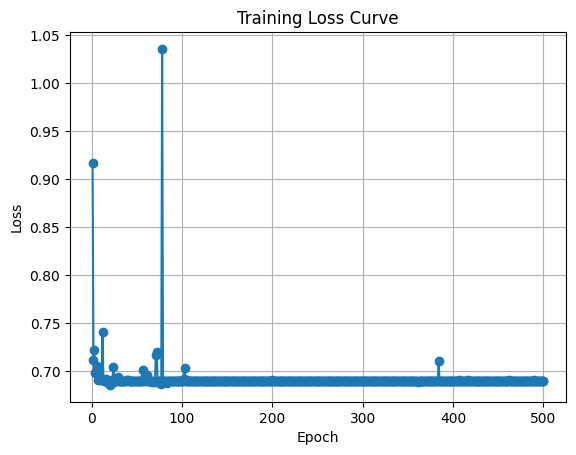

Accuracy: 0.5645


In [270]:
train_dataset,train_loader,X_test_tensor,y_test_tensor=get_datas('../../data/extract_dengue_data.csv')
input_size=X_test_tensor.shape[1]

best_config=tune_nn(input_size,train_loader)
print(best_config)
model=optimized_nn(input_size,train_loader,best_config)
test_classification_nn(X_test_tensor,y_test_tensor,model)